In [1]:
import torch
import MiniFL as mfl

In [2]:
NUM_CLIENTS = 10
STEPS = 1000


In [3]:
def get_task():
    return mfl.tasks.get_svm_regression_fns(
        data_path="gisette_scale",
        num_clients=NUM_CLIENTS,
        batch_size=-1,
    )

In [4]:
SIZE = get_task()[0].size()

In [5]:
def measure_all(gamma_multiplier, steps=STEPS):
    print(f"Measuring {gamma_multiplier=}")
    master, clients = mfl.algorithms.get_gd_master_and_clients(
        *get_task(),
        gamma_multiplier=gamma_multiplier,
    )
    gd_metrics = mfl.algorithms.run_algorithm_with_threads(master, clients, steps)

    master, clients = mfl.algorithms.get_ef21_master_and_clients(
        *get_task(),
        compressors=[mfl.compressors.TopSigmaCompressor(SIZE, sigmas=0.613) for _ in range(NUM_CLIENTS)],
        gamma_multiplier=gamma_multiplier,
    )
    sigma_metrics = mfl.algorithms.run_algorithm_with_threads(master, clients, steps)

    master, clients = mfl.algorithms.get_ef21_master_and_clients(
        *get_task(),
        compressors=[mfl.compressors.EdenContractiveCompressor(SIZE, bits=1.57) for _ in range(NUM_CLIENTS)],
        gamma_multiplier=gamma_multiplier,
    )
    eden_metrics = mfl.algorithms.run_algorithm_with_threads(master, clients, steps)

    master, clients = mfl.algorithms.get_ef21_master_and_clients(
        *get_task(),
        compressors=[mfl.compressors.TopKCompressor(SIZE, p=1.57 / 32) for _ in range(NUM_CLIENTS)],
        gamma_multiplier=gamma_multiplier,
    )
    top_metrics = mfl.algorithms.run_algorithm_with_threads(master, clients, steps)

    master, clients = mfl.algorithms.get_ef21_master_and_clients(
        *get_task(),
        compressors=[mfl.compressors.RandKContractiveCompressor(SIZE, p=1.57*1/32) for _ in range(NUM_CLIENTS)],
        gamma_multiplier=gamma_multiplier,
    )
    rand_metrics = mfl.algorithms.run_algorithm_with_threads(master, clients, steps)

    return gd_metrics, sigma_metrics, eden_metrics, top_metrics, rand_metrics

In [6]:
GD_METRICS = {}
SIGMA_METRICS = {}
EDEN_METRICS = {}
TOP_METRICS = {}
RAND_METRICS = {}

GAMMA_MULTIPLIERS = (1, 4, 16, 64, 256, 1024, 4096, 8192, 16384)

for gamma_multiplier in GAMMA_MULTIPLIERS:
    gd_metrics, sigma_metrics, eden_metrics, top_metrics, rand_metrics = measure_all(gamma_multiplier)
    GD_METRICS[gamma_multiplier] = gd_metrics
    SIGMA_METRICS[gamma_multiplier] = sigma_metrics
    EDEN_METRICS[gamma_multiplier] = eden_metrics
    TOP_METRICS[gamma_multiplier] = top_metrics
    RAND_METRICS[gamma_multiplier] = rand_metrics


Measuring gamma_multiplier=1


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

GD_COLORS = plt.get_cmap("Greys")(np.linspace(0.5, 1, len(GAMMA_MULTIPLIERS)))
SIGMA_COLORS = plt.get_cmap("YlGn")(np.linspace(0.5, 1, len(GAMMA_MULTIPLIERS)))
EDEN_COLORS = plt.get_cmap("YlOrRd")(np.linspace(0.5, 1, len(GAMMA_MULTIPLIERS)))
TOP_COLORS = plt.get_cmap("YlOrBr")(np.linspace(0.5, 1, len(GAMMA_MULTIPLIERS)))
RAND_COLORS = plt.get_cmap("Oranges")(np.linspace(0.5, 1, len(GAMMA_MULTIPLIERS)))

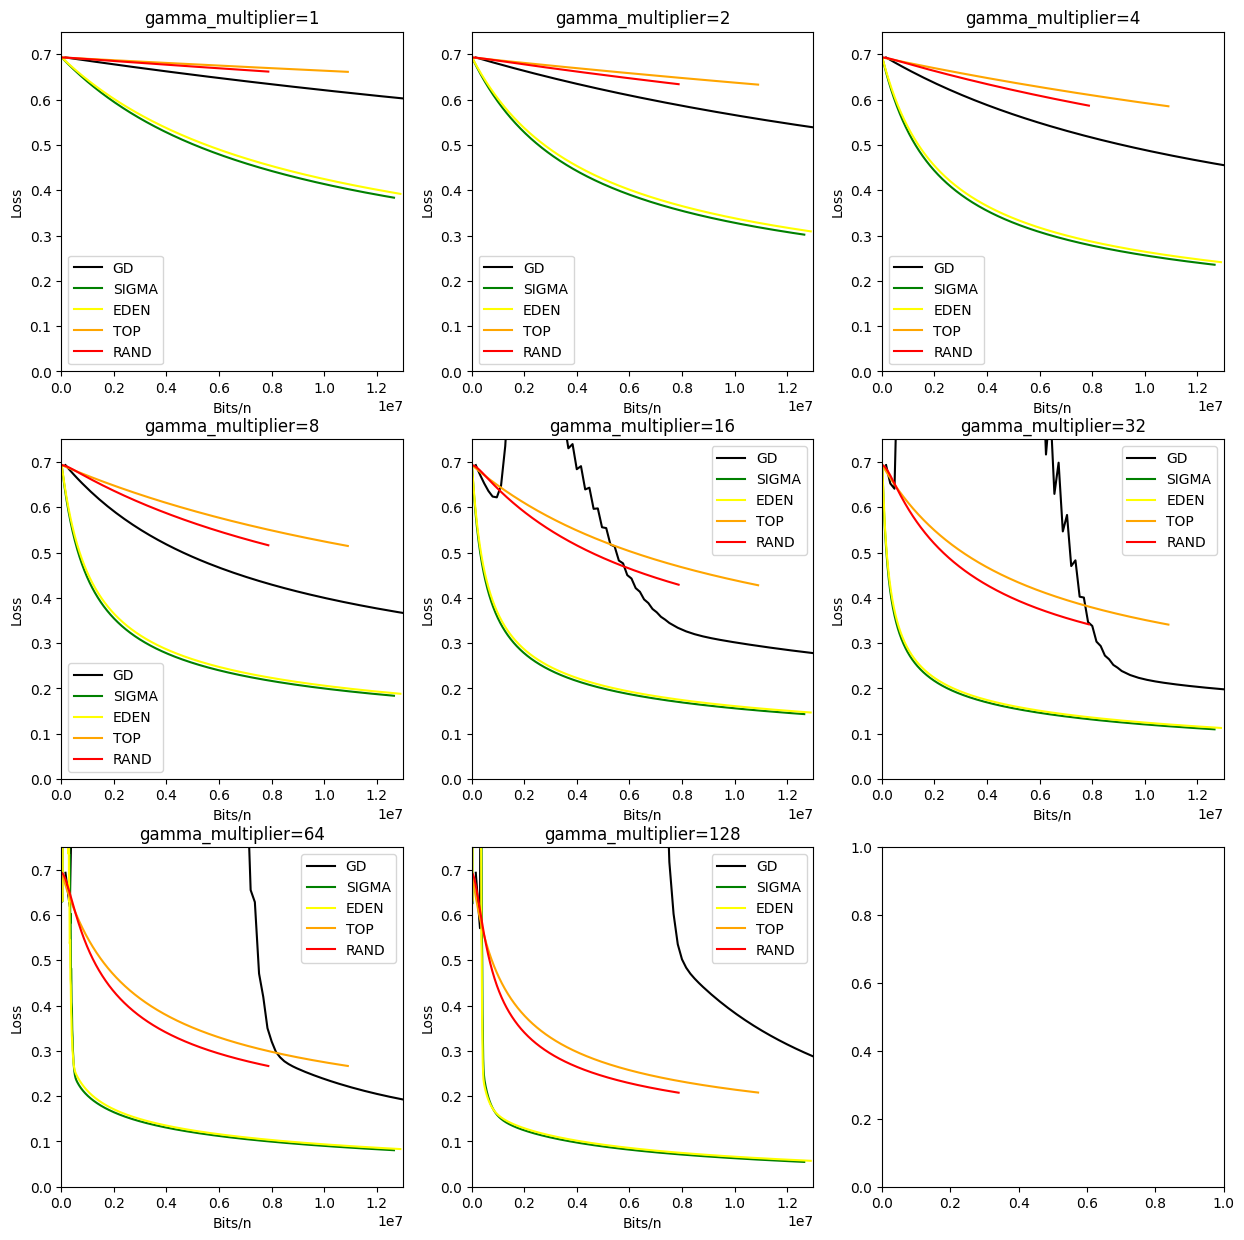

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, gamma_multiplier in enumerate(GAMMA_MULTIPLIERS):
    ax = axes[i//3][i%3]
    ax.set_title(f"gamma_multiplier={gamma_multiplier}")

    ax.plot([metrics.total_bits_received/NUM_CLIENTS for metrics in GD_METRICS[gamma_multiplier]], [metrics.value for metrics in GD_METRICS[gamma_multiplier]], color="black", label="GD")
    ax.plot([metrics.total_bits_received/NUM_CLIENTS for metrics in SIGMA_METRICS[gamma_multiplier]], [metrics.value for metrics in SIGMA_METRICS[gamma_multiplier]], color="green", label="SIGMA")
    ax.plot([metrics.total_bits_received/NUM_CLIENTS for metrics in EDEN_METRICS[gamma_multiplier]], [metrics.value for metrics in EDEN_METRICS[gamma_multiplier]], color="yellow", label="EDEN")
    ax.plot([metrics.total_bits_received/NUM_CLIENTS for metrics in TOP_METRICS[gamma_multiplier]], [metrics.value for metrics in TOP_METRICS[gamma_multiplier]], color="orange", label="TOP")
    ax.plot([metrics.total_bits_received/NUM_CLIENTS for metrics in RAND_METRICS[gamma_multiplier]], [metrics.value for metrics in RAND_METRICS[gamma_multiplier]], color="red", label="RAND")

    ax.set_xlim(0, 1.3*1e7)
    ax.set_ylim(0, 0.75)
    ax.set_xlabel("Bits/n")
    ax.set_ylabel("Loss")
    ax.legend()


NameError: name 'GAMMA_MULTIPLIERS' is not defined

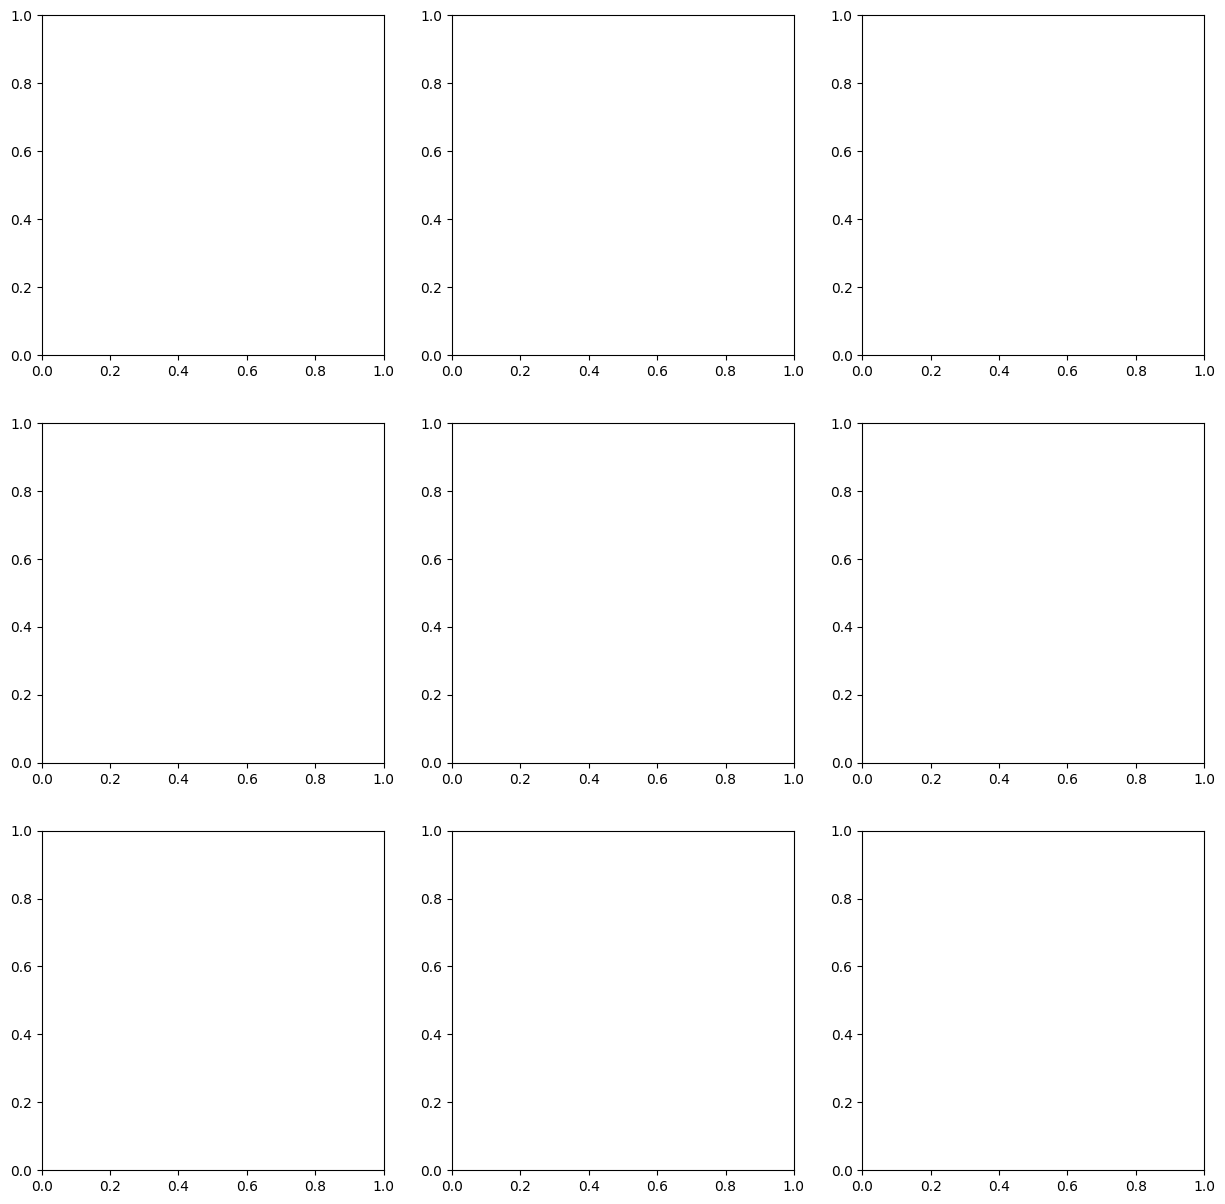

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, gamma_multiplier in enumerate(GAMMA_MULTIPLIERS):
    ax = axes[i//3][i%3]
    ax.set_title(f"gamma_multiplier={gamma_multiplier}")

    ax.plot([metrics.total_bits_received/NUM_CLIENTS for metrics in GD_METRICS[gamma_multiplier]], [metrics.grad_norm for metrics in GD_METRICS[gamma_multiplier]], color="black", label="GD")
    ax.plot([metrics.total_bits_received/NUM_CLIENTS for metrics in SIGMA_METRICS[gamma_multiplier]], [metrics.grad_norm for metrics in SIGMA_METRICS[gamma_multiplier]], color="green", label="SIGMA")
    ax.plot([metrics.total_bits_received/NUM_CLIENTS for metrics in EDEN_METRICS[gamma_multiplier]], [metrics.grad_norm for metrics in EDEN_METRICS[gamma_multiplier]], color="yellow", label="EDEN")
    ax.plot([metrics.total_bits_received/NUM_CLIENTS for metrics in TOP_METRICS[gamma_multiplier]], [metrics.grad_norm for metrics in TOP_METRICS[gamma_multiplier]], color="orange", label="TOP")
    ax.plot([metrics.total_bits_received/NUM_CLIENTS for metrics in RAND_METRICS[gamma_multiplier]], [metrics.grad_norm for metrics in RAND_METRICS[gamma_multiplier]], color="red", label="RAND")

    ax.set_yscale("log")
    ax.set_xlim(0, 1.3*1e7)
    ax.set_ylim(0.1, 0.001)
    ax.set_xlabel("bits/n")
    ax.set_ylabel("Grad Norm")
    ax.legend()
